Libraries

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import shutil
import random
from torchvision import datasets, transforms
#from tqdm import tqdm, trange
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import get_linear_schedule_with_warmup

**download dataset**

In [ ]:
train_tfms = transforms.Compose([transforms.ToTensor(),
                         transforms.RandomRotation(15)])

In [ ]:
dataset=datasets.MNIST(root="pics",
                              train=True,
                              download=True,
                              transform=train_tfms)

test_dataset=datasets.MNIST(root="pics",
                              train=False,
                              download=True,
                              transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 323146544.31it/s]

Extracting pics/MNIST/raw/train-images-idx3-ubyte.gz to pics/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 18963007.80it/s]

Extracting pics/MNIST/raw/train-labels-idx1-ubyte.gz to pics/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 138118936.66it/s]


Extracting pics/MNIST/raw/t10k-images-idx3-ubyte.gz to pics/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23260718.89it/s]

Extracting pics/MNIST/raw/t10k-labels-idx1-ubyte.gz to pics/MNIST/raw



Dataset split

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

Transforms-with normalization

dataset playing

In [ ]:
len(test_dataset)

10000

In [ ]:
image,label=train_ds[0]
image.shape

torch.Size([1, 28, 28])

In [ ]:
train_ds[0][0].shape

torch.Size([1, 28, 28])

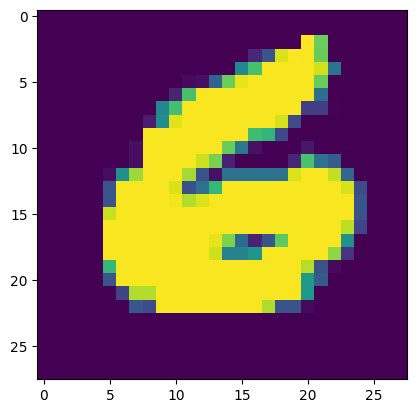

In [ ]:
plt.imshow(image.permute(1,2,0))

In [ ]:
def show_example(img, label):
    print('Label: ',label)
    plt.imshow(img.permute(1, 2, 0),cmap='gray_r')

Label:  1


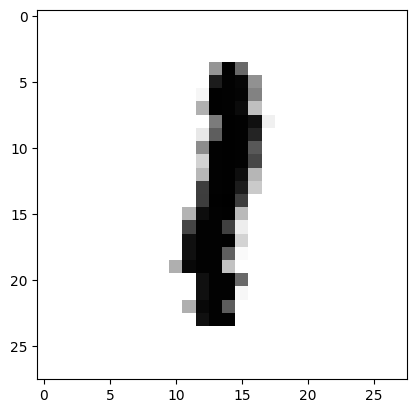

In [ ]:
show_example(*train_ds[1000])

Dataloader

In [ ]:
#arguments
train_batch_size_1=32
train_batch_size_2=64
train_batch_size_3=128
train_batch_size_4=256

val_batch_size=512
test_batch_size=512
input_size=28*28
classes=10

In [ ]:
train_loader_1=DataLoader(train_ds,train_batch_size_1,shuffle=True)
train_loader_2=DataLoader(train_ds,train_batch_size_2,shuffle=True)
train_loader_3=DataLoader(train_ds,train_batch_size_3,shuffle=True)
train_loader_4=DataLoader(train_ds,train_batch_size_4,shuffle=True)

val_loader=DataLoader(val_ds,val_batch_size)
test_loader=DataLoader(test_dataset,val_batch_size)

Arguments

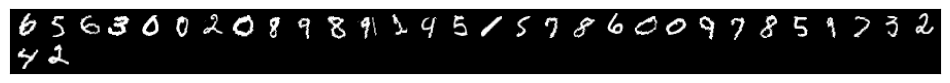

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=30).permute(1, 2, 0),cmap='gray_r')
        break

show_batch(train_loader_1)

USE GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def device_type():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


def to_device(data,device):#transfer to gpu
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking= True)


class deviceDataloader():#wrap dataloaders
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for batchy in self.dl:
      yield to_device(batchy,self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device=device_type()
device

device(type='cuda')

In [ ]:
train_loader_1=deviceDataloader(train_loader_1,device)
train_loader_2=deviceDataloader(train_loader_2,device)
train_loader_3=deviceDataloader(train_loader_3,device)
train_loader_4=deviceDataloader(train_loader_4,device)

val_loader=deviceDataloader(val_loader,device)
test_loader=deviceDataloader(test_loader,device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss,acc

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f} , train_loss: {:.4f} , train_acc: {:.4f} , val_loss: {:.4f} , val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

In [ ]:
# def conv_block(in_channels, out_channels, pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#               nn.BatchNorm2d(out_channels),
#               nn.ReLU(inplace=True)]
#     if pool: layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)

class MODEL(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,out_channels=10, kernel_size=3, stride=1, padding=0)#10*26*26
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=48, kernel_size=3, stride=1, padding=0)#48*24*24

        self.norm=nn.BatchNorm2d(48)
        self.act=nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2) #48*12*12
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2) #48*6*6

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(48*6*6, 10))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.act(x)
        x = self.classifier(x)
        return x

In [ ]:
model_1 = to_device(MODEL(), device)
model_1

MODEL(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

Training Steps

In [ ]:
args = {}

args["num_train_epochs"] = 8
args["optimizer"] = torch.optim.Adam
args["learning_rate"] = 1e-3
args["weight_decay"] = 0
args["grad_clip"] = False
args["adam_epsilon"] = 1e-8
args["output_dir"] = "./output/"
args["max_grad_norm"] = 1.0
args["save_steps"] = 1
args["dropout"] = 0.3
args["lambda"] = 0.001

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(args,model,train_loader,val_loader):
  torch.cuda.empty_cache()
  history=[]

  optimizer=args["optimizer"](model.parameters(), lr=args["learning_rate"],weight_decay=args["weight_decay"])
  sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,args["learning_rate"], epochs=args["num_train_epochs"],
                                            steps_per_epoch=len(train_loader))

  for epoch in range(args["num_train_epochs"]):
    model.train()
    train_losses=[]
    train_accs=[]
    lrs=[]
    for batch in train_loader:
          loss,acc=model.training_step(batch)
          train_losses.append(loss)
          train_accs.append(acc)
          loss.backward()

          # Gradient clipping
          if args["grad_clip"]:
            nn.utils.clip_grad_value_(model.parameters(), args["grad_clip"])

          optimizer.step()
          optimizer.zero_grad()

          # Record & update learning rate
          lrs.append(get_lr(optimizer))
          sched.step()

    #validation
    result=evaluate(model,val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    result['train_acc']=torch.stack(train_accs).mean().item()
    result["lrs"]=lrs
    model.epoch_end(epoch,result)
    history.append(result)

  return history

TRAIN/TEST

In [ ]:
result0=evaluate(model_1,test_loader)
result0

{'val_loss': 2.3034520149230957, 'val_acc': 0.08211741596460342}

In [ ]:
#%%time
try1=fit(args,model_1,train_loader_1,val_loader)

Epoch [0], last_lr: 0.00040 , train_loss: 0.6824 , train_acc: 0.7905 , val_loss: 0.1986 , val_acc: 0.9439
Epoch [1], last_lr: 0.00094 , train_loss: 0.1765 , train_acc: 0.9459 , val_loss: 0.1194 , val_acc: 0.9635
Epoch [2], last_lr: 0.00097 , train_loss: 0.1289 , train_acc: 0.9601 , val_loss: 0.1007 , val_acc: 0.9670
Epoch [3], last_lr: 0.00081 , train_loss: 0.1029 , train_acc: 0.9671 , val_loss: 0.0805 , val_acc: 0.9753
Epoch [4], last_lr: 0.00056 , train_loss: 0.0902 , train_acc: 0.9721 , val_loss: 0.0713 , val_acc: 0.9780
Epoch [5], last_lr: 0.00028 , train_loss: 0.0764 , train_acc: 0.9764 , val_loss: 0.0651 , val_acc: 0.9816
Epoch [6], last_lr: 0.00008 , train_loss: 0.0642 , train_acc: 0.9801 , val_loss: 0.0592 , val_acc: 0.9811
Epoch [7], last_lr: 0.00000 , train_loss: 0.0612 , train_acc: 0.9812 , val_loss: 0.0576 , val_acc: 0.9825


time taken for model_1=6 min 34s

In [ ]:
evaluate(model_1,test_loader)

{'val_loss': 0.03469051048159599, 'val_acc': 0.988608717918396}

In [ ]:
evaluate(model_1,val_loader)

{'val_loss': 0.05809122323989868, 'val_acc': 0.9831514358520508}

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    train_losses = [x.get('train_acc') for x in history]
    val_losses = [x['val_acc'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

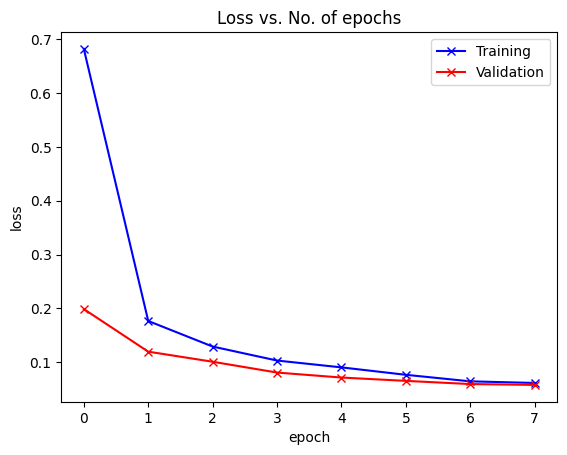

In [ ]:
plot_losses(try1)

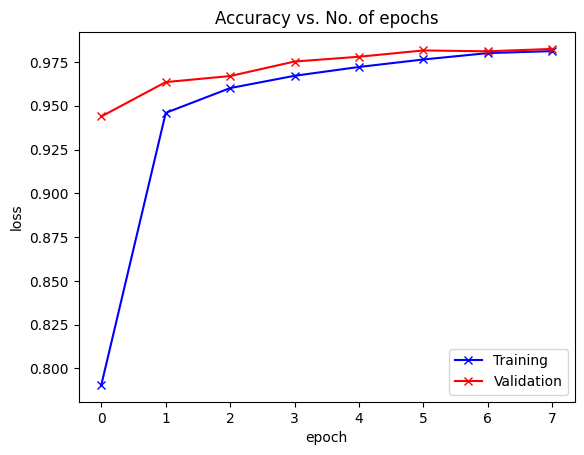

In [ ]:
plot_accuracies(try1)

In [ ]:
#save

torch.save(model_1.state_dict(),'model_1_bs_32.pth')

Model_2

In [ ]:
model_2 = to_device(MODEL(), device)
model_2

MODEL(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
%%time
try2=fit(args,model_2,train_loader_2,val_loader)

Epoch [0], last_lr: 0.00040 , train_loss: 0.8322 , train_acc: 0.7500 , val_loss: 0.2295 , val_acc: 0.9407
Epoch [1], last_lr: 0.00094 , train_loss: 0.1866 , train_acc: 0.9432 , val_loss: 0.1576 , val_acc: 0.9531
Epoch [2], last_lr: 0.00097 , train_loss: 0.1358 , train_acc: 0.9576 , val_loss: 0.0947 , val_acc: 0.9716
Epoch [3], last_lr: 0.00081 , train_loss: 0.1088 , train_acc: 0.9663 , val_loss: 0.0838 , val_acc: 0.9747
Epoch [4], last_lr: 0.00056 , train_loss: 0.0937 , train_acc: 0.9704 , val_loss: 0.0809 , val_acc: 0.9747
Epoch [5], last_lr: 0.00028 , train_loss: 0.0823 , train_acc: 0.9745 , val_loss: 0.0683 , val_acc: 0.9796
Epoch [6], last_lr: 0.00008 , train_loss: 0.0734 , train_acc: 0.9777 , val_loss: 0.0649 , val_acc: 0.9796
Epoch [7], last_lr: 0.00000 , train_loss: 0.0691 , train_acc: 0.9784 , val_loss: 0.0622 , val_acc: 0.9806
CPU times: user 5min 53s, sys: 1.27 s, total: 5min 54s
Wall time: 5min 58s


In [ ]:
evaluate(model_2,test_loader)

{'val_loss': 0.038498327136039734, 'val_acc': 0.9880228042602539}

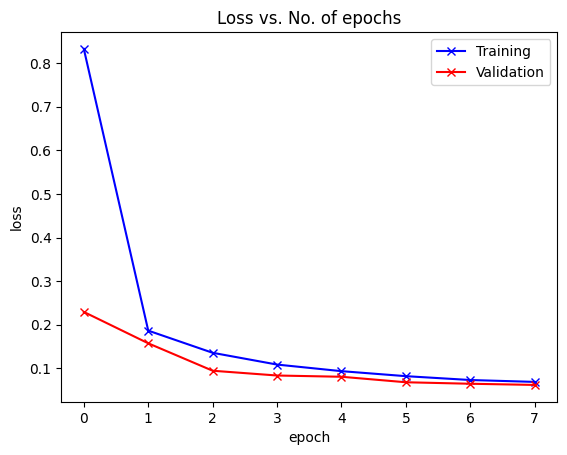

In [ ]:
plot_losses(try2)

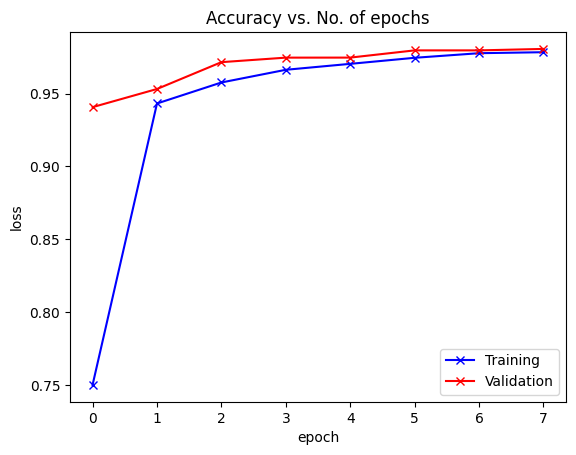

In [ ]:
plot_accuracies(try2)

Model_2 again because sus accuracies in first epoch

In [ ]:
model_2b = to_device(MODEL(), device)
model_2b

MODEL(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
evaluate(model_2,val_loader)

{'val_loss': 0.06305579096078873, 'val_acc': 0.9807214736938477}

In [ ]:
%%time
try2b=fit(args,model_2b,train_loader_2,val_loader)

Epoch [0], last_lr: 0.00040 , train_loss: 0.7971 , train_acc: 0.7583 , val_loss: 0.2382 , val_acc: 0.9353
Epoch [1], last_lr: 0.00094 , train_loss: 0.1955 , train_acc: 0.9413 , val_loss: 0.1257 , val_acc: 0.9621


KeyboardInterrupt: ignored

In [ ]:
model_3= to_device(MODEL(), device)
model_3

MODEL(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
evaluate(model_3,val_loader)

{'val_loss': 2.2994942665100098, 'val_acc': 0.07607422024011612}

In [ ]:
evaluate(model_3,train_loader_3)

{'val_loss': 2.299140691757202, 'val_acc': 0.07631473243236542}

In [ ]:
%%time
try3=fit(args,model_3,train_loader_3,val_loader)

Epoch [0], last_lr: 0.00039 , train_loss: 0.9649 , train_acc: 0.7078 , val_loss: 0.2893 , val_acc: 0.9219
Epoch [1], last_lr: 0.00094 , train_loss: 0.2130 , train_acc: 0.9380 , val_loss: 0.1510 , val_acc: 0.9538
Epoch [2], last_lr: 0.00097 , train_loss: 0.1416 , train_acc: 0.9569 , val_loss: 0.1123 , val_acc: 0.9659
Epoch [3], last_lr: 0.00081 , train_loss: 0.1151 , train_acc: 0.9650 , val_loss: 0.0890 , val_acc: 0.9743
Epoch [4], last_lr: 0.00056 , train_loss: 0.0994 , train_acc: 0.9694 , val_loss: 0.0965 , val_acc: 0.9711
Epoch [5], last_lr: 0.00028 , train_loss: 0.0908 , train_acc: 0.9720 , val_loss: 0.0788 , val_acc: 0.9760
Epoch [6], last_lr: 0.00008 , train_loss: 0.0842 , train_acc: 0.9735 , val_loss: 0.0717 , val_acc: 0.9774
Epoch [7], last_lr: 0.00000 , train_loss: 0.0810 , train_acc: 0.9752 , val_loss: 0.0722 , val_acc: 0.9774
CPU times: user 5min 49s, sys: 1.06 s, total: 5min 50s
Wall time: 5min 53s


In [ ]:
evaluate(model_3,test_loader)

Model 4

In [ ]:
model_4= to_device(MODEL(), device)
model_4

MODEL(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
%%time
try4=fit(args,model_4,train_loader_4,val_loader)

Epoch [0], last_lr: 0.00039 , train_loss: 1.3190 , train_acc: 0.5830 , val_loss: 0.4165 , val_acc: 0.8840
Epoch [1], last_lr: 0.00094 , train_loss: 0.2805 , train_acc: 0.9198 , val_loss: 0.1687 , val_acc: 0.9522
Epoch [2], last_lr: 0.00097 , train_loss: 0.1617 , train_acc: 0.9519 , val_loss: 0.1175 , val_acc: 0.9657
Epoch [3], last_lr: 0.00081 , train_loss: 0.1307 , train_acc: 0.9591 , val_loss: 0.0999 , val_acc: 0.9704
Epoch [4], last_lr: 0.00056 , train_loss: 0.1128 , train_acc: 0.9651 , val_loss: 0.0931 , val_acc: 0.9731
Epoch [5], last_lr: 0.00028 , train_loss: 0.1017 , train_acc: 0.9680 , val_loss: 0.0875 , val_acc: 0.9748
Epoch [6], last_lr: 0.00008 , train_loss: 0.0993 , train_acc: 0.9703 , val_loss: 0.0844 , val_acc: 0.9739
Epoch [7], last_lr: 0.00000 , train_loss: 0.0928 , train_acc: 0.9717 , val_loss: 0.0814 , val_acc: 0.9764
CPU times: user 5min 52s, sys: 1.11 s, total: 5min 53s
Wall time: 6min 8s


Model 5

In [ ]:
model_5= to_device(MODEL(), device)
model_5

MODEL(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
train_batch_size_5=400
train_loader_5=DataLoader(train_ds,train_batch_size_5,shuffle=True)

In [ ]:
train_loader_5=deviceDataloader(train_loader_5,device)

In [ ]:
%%time
try5=fit(args,model_5,train_loader_5,val_loader)

Epoch [0], last_lr: 0.00039 , train_loss: 1.4578 , train_acc: 0.5296 , val_loss: 0.4619 , val_acc: 0.8767
Epoch [1], last_lr: 0.00094 , train_loss: 0.3262 , train_acc: 0.9079 , val_loss: 0.2062 , val_acc: 0.9416
Epoch [2], last_lr: 0.00097 , train_loss: 0.1857 , train_acc: 0.9457 , val_loss: 0.1446 , val_acc: 0.9585
Epoch [3], last_lr: 0.00081 , train_loss: 0.1444 , train_acc: 0.9574 , val_loss: 0.1139 , val_acc: 0.9675
Epoch [4], last_lr: 0.00056 , train_loss: 0.1245 , train_acc: 0.9628 , val_loss: 0.1090 , val_acc: 0.9667
Epoch [5], last_lr: 0.00028 , train_loss: 0.1132 , train_acc: 0.9661 , val_loss: 0.0967 , val_acc: 0.9724
Epoch [6], last_lr: 0.00008 , train_loss: 0.1072 , train_acc: 0.9676 , val_loss: 0.0910 , val_acc: 0.9737
Epoch [7], last_lr: 0.00000 , train_loss: 0.1025 , train_acc: 0.9693 , val_loss: 0.0898 , val_acc: 0.9744
CPU times: user 5min 47s, sys: 1.11 s, total: 5min 48s
Wall time: 5min 54s


Compare

In [ ]:
def compare_train_losses():
    train_losses_1 = [x.get('train_loss') for x in try1]
    train_losses_2 = [x.get('train_loss') for x in try2]
    train_losses_3 = [x.get('train_loss') for x in try3]
    train_losses_4 = [x.get('train_loss') for x in try4]
    train_losses_5 = [x.get('train_loss') for x in try5]

    plt.plot(train_losses_1)
    plt.plot(train_losses_2)
    plt.plot(train_losses_3)
    plt.plot(train_losses_4)
    plt.plot(train_losses_5)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['32', '64','128','256','400'])
    plt.title('Training Loss vs. No. of epochs');

In [ ]:
def compare_val_losses():
    val_losses_1 = [x.get('val_loss') for x in try1]
    val_losses_2 = [x.get('val_loss') for x in try2]
    val_losses_3 = [x.get('val_loss') for x in try3]
    val_losses_4 = [x.get('val_loss') for x in try4]
    val_losses_5 = [x.get('val_loss') for x in try5]

    plt.plot(val_losses_1)
    plt.plot(val_losses_2)
    plt.plot(val_losses_3)
    plt.plot(val_losses_4)
    plt.plot(val_losses_5)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['32', '64','128','256','400'])
    plt.title('Val Loss vs. No. of epochs');

In [ ]:
def compare_train_accs():
    val_acc_1 = [x.get('train_acc') for x in try1]
    val_acc_2 = [x.get('train_acc') for x in try2]
    val_acc_3 = [x.get('train_acc') for x in try3]
    val_acc_4 = [x.get('train_acc') for x in try4]
    val_acc_5 = [x.get('train_acc') for x in try5]

    plt.plot(val_acc_1)
    plt.plot(val_acc_2)
    plt.plot(val_acc_3)
    plt.plot(val_acc_4)
    plt.plot(val_acc_5)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['32', '64','128','256','400'])
    plt.title('Train Accuracy vs. No. of epochs');

In [ ]:
def compare_val_accs():
    val_acc_1 = [x.get('val_acc') for x in try1]
    val_acc_2 = [x.get('val_acc') for x in try2]
    val_acc_3 = [x.get('val_acc') for x in try3]
    val_acc_4 = [x.get('val_acc') for x in try4]
    val_acc_5 = [x.get('val_acc') for x in try5]

    plt.plot(val_acc_1)
    plt.plot(val_acc_2)
    plt.plot(val_acc_3)
    plt.plot(val_acc_4)
    plt.plot(val_acc_5)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['32', '64','128','256','400'])
    plt.title('Val Accuracy vs. No. of epochs');

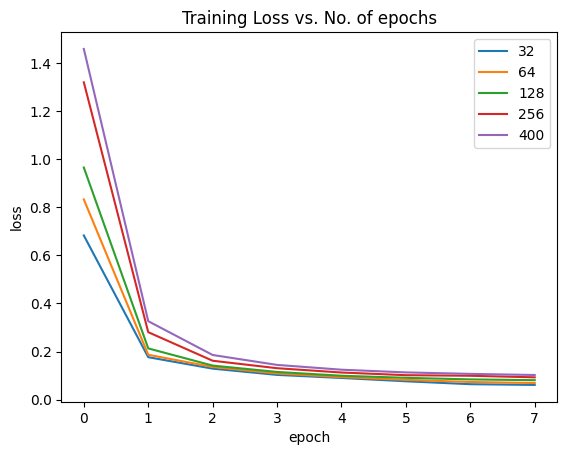

In [ ]:
compare_train_losses()

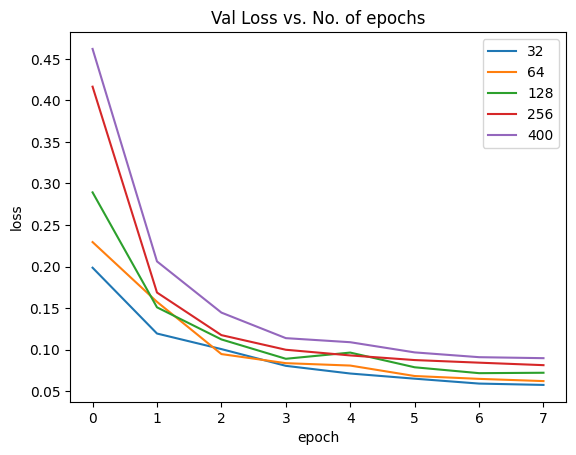

In [ ]:
compare_val_losses()

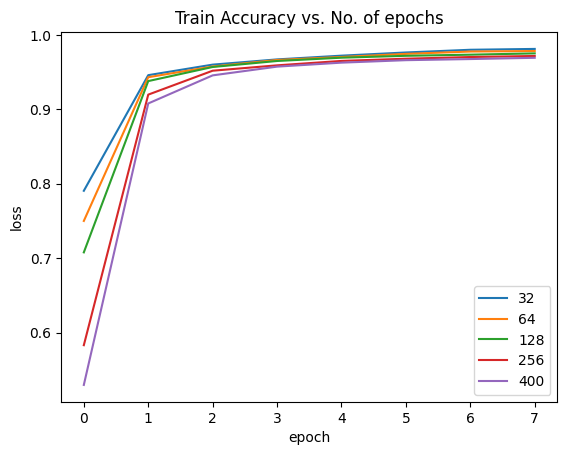

In [ ]:
compare_train_accs()

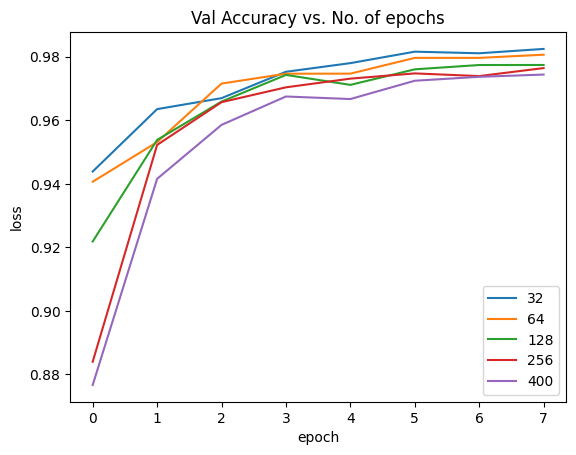

In [ ]:
compare_val_accs()

In [ ]:
#save

torch.save(model_1.state_dict(),'model_2_bs_64.pth')

In [ ]:
#save

torch.save(model_1.state_dict(),'model_3_bs_128.pth')

In [ ]:
#save

torch.save(model_1.state_dict(),'model_4_bs_256.pth')

In [ ]:
#save

torch.save(model_1.state_dict(),'model_5_bs_400.pth')

Conclusion-
Smaller batchsize are more favourable for faster and accurate training
Although smaller batches take longer time to train